# Classification Between Group3+4 and Rest

## Required Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier

## Data Preprocessing/Loading 

In [ ]:
# load data
file_path = "features.csv"
df = pd.read_csv(file_path)
df.head()

In [ ]:
# obtain list of features selected from LASSO
# reduced_feats_path = "/Users/samwwong/Desktop/Michael Zhang/reduced_molec.xlsx"
# reduced_features = pd.read_excel(reduced_feats_path)
# reduced_features_list = reduced_features.loc[reduced_features['group3_rest'].isnull() == False,
#                                              ['group3_rest']].values.tolist()
# reduced_features_list = [item for sublist in reduced_features_list for item in sublist]
# features_after_lasso = df[reduced_features_list]
sex_binarized = df['sex'].map(lambda sex: {'F': 0, 'M': 1}.get(sex, -1)).to_numpy()
df['sex'] = sex_binarized
df['age'] = df['age'].map(lambda x: 0 if pd.isna(x) else x)
# print(reduced_features_list)
reduced_features_list = ['sex', 'age', 't1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 't1_log-sigma-3-mm-3D_firstorder_Median', 't1_log-sigma-3-mm-3D_glcm_ClusterProminence', 't1_log-sigma-3-mm-3D_glrlm_LowGrayLevelRunEmphasis', 't1_log-sigma-5-mm-3D_glszm_GrayLevelVariance', 't1_original_glszm_LargeAreaHighGrayLevelEmphasis', 't1_original_glszm_LargeAreaLowGrayLevelEmphasis', 't1_original_shape_Flatness', 't1_wavelet-HHL_firstorder_Skewness', 't1_wavelet-HLL_firstorder_Mean', 't1_wavelet-HLL_glcm_Correlation', 't1_wavelet-LHL_glcm_Correlation', 't1_wavelet-LLH_glszm_LargeAreaLowGrayLevelEmphasis', 't1_wavelet-LLL_firstorder_Skewness', 't1_wavelet-LLL_glszm_ZoneVariance', 't2_log-sigma-1-mm-3D_firstorder_Mean', 't2_log-sigma-1-mm-3D_firstorder_Median', 't2_log-sigma-1-mm-3D_glcm_Correlation', 't2_log-sigma-5-mm-3D_firstorder_Kurtosis', 't2_log-sigma-5-mm-3D_glrlm_RunLengthNonUniformity', 't2_log-sigma-5-mm-3D_glszm_SmallAreaEmphasis', 't2_original_glszm_GrayLevelNonUniformity', 't2_wavelet-HHH_glrlm_RunPercentage', 't2_wavelet-HHH_glszm_LargeAreaEmphasis', 't2_wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis', 't2_wavelet-HHL_glcm_ClusterProminence', 't2_wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis', 't2_wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis', 't2_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 't2_wavelet-HLL_firstorder_Mean', 't2_wavelet-LHH_firstorder_Mean', 't2_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', 't2_wavelet-LHL_glcm_Idn', 't2_wavelet-LLL_firstorder_Energy', 't2_wavelet-LLL_glcm_JointAverage', 't1_log-sigma-3-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 't1_wavelet-HHH_firstorder_Skewness', 't1_wavelet-HHH_glszm_LargeAreaHighGrayLevelEmphasis', 't1_wavelet-HHL_glcm_ClusterProminence', 't1_wavelet-LHH_firstorder_Median', 't2_log-sigma-5-mm-3D_glcm_Imc2', 't2_original_glcm_Idmn', 't2_wavelet-LLL_firstorder_Median', 't2_wavelet-HHH_firstorder_Skewness', 't2_original_firstorder_Kurtosis', 't2_wavelet-LLL_firstorder_TotalEnergy']
print(len(reduced_features_list))
features_after_lasso = df[reduced_features_list]

In [ ]:
# Binarizing target
target = df["molecular"]

# Marking 0 as rest and 1 group3+4
# mapping_dict = {0: 'rest', 1: 'group3'}
# target = target.map(dict(rest = 0, group3 = 1))
target = target.map({
    'wnt': 0,
    'shh': 0,
    'group3': 1,
    'group4': 1,
})
print(target.value_counts())

In [ ]:
# Train/test split
train_idx = df['split'] != 'test'
test_idx = ~train_idx

X_train = features_after_lasso[train_idx]
X_test = features_after_lasso[test_idx]
y_train = target[train_idx]
y_test = target[test_idx]

# X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target,
#                                                     test_size = 0.25, random_state = 42)
print("TRAIN")
print(y_train.value_counts())

print("TEST")
print(y_test.value_counts())

### Resampling to Correct for Imbalance

In [ ]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['molecular'] == 0]
X_1 = X[X['molecular'] == 1]

In [ ]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [ ]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]
print(y_train.value_counts())

### Standardizing Features

In [ ]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [ ]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

## Modeling

### User Defined Functions for Metrics

In [ ]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.4f} - {:0.4}]".format(name, 
    confidence_lower, confidence_upper))

In [ ]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    return TN / (TN + FP) 
    #return round((TN / (TN + FP)),4) 

In [ ]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return round((TP/(TP+FP)),4)

In [ ]:
def negative_pv_score(y_true, y_pred):
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return round((TN/(TN+FN)),4)        

In [ ]:
def print_metrics(y_test, y_pred):
    print("Sens Score: " + str.format('{0:.4f}', (recall_score(y_test, y_pred))))
    print("Spec Score: " + str.format('{0:.4f}', (specificity_score(y_test.to_numpy(), y_pred))))
    print("PPV Score: " + str.format('{0:.4f}', (positive_pv_score(y_test.to_numpy(), y_pred))))
    print("NPV Score: " + str.format('{0:.4f}', (negative_pv_score(y_test.to_numpy(), y_pred))))
    print(f"Acc Score: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")

In [ ]:
def plot_roc_curve(model_name):
    sns.set()
    plt.figure(figsize=(7, 7))

    ns_preds = [0 for _ in range(len(y_test))]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name)
    plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

    plt.legend(loc='lower right')
    plt.title(f'{model_name}: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    short_auc = round(auc,4)
    plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
    plt.show()

In [ ]:
def create_confusion_matrix(model_name, model, X, y):
    matrix = ConfusionMatrixDisplay.from_estimator(model, X, y,
                               cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show(matrix)
    plt.show()

### User Defined Functions for Modeling

In [ ]:
def grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

### SVM

#### Grid Search for Hyperparameters

In [ ]:
svm_model = svm.SVC()
svm_grid_params = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

grid_search(svm_model, svm_grid_params, X_train, y_train)

#### Model Performance

In [ ]:
svm_model = svm.SVC(C = 10, gamma = 0.01, kernel = 'rbf', probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)
print(233)

In [ ]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print("AUC: " + str.format('{0:.4f}',auc))

In [ ]:
plot_roc_curve('SVM')

In [ ]:
create_confusion_matrix('SVM', svm_model, X_test, y_test)

### Logistic Regression

#### Grid Search for Hyperparameters

In [ ]:
lr_model = LogisticRegression()
lr_grid_params = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

grid_search(lr_model, lr_grid_params, X_train, y_train)

#### Model Performance

In [ ]:
lr_model = LogisticRegression(penalty = 'l2', C = 10)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)

In [ ]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str.format('{0:.4f}',auc))

In [ ]:
plot_roc_curve('LR')

In [ ]:
create_confusion_matrix('Logistic Regression', lr_model, X_test, y_test)

In [ ]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Top 15 Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices[-15:])), importances[indices[-15:]], color='b', align='center')
plt.xlim(0, 0.08)
for index, value in enumerate(importances[indices[-15:]]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)

plt.yticks(range(len(indices[-15:])), [feature_names[i] for i in indices[-15:]], fontsize=14)

plt.xlabel('Relative Importance',fontsize=18)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(fontsize=14)

plt.show()

In [ ]:
feature_names = X_test.columns.to_list()

importances_2 = lr_model.coef_[0]
importances_2 = (importances_2) / np.sum(np.abs(importances_2))

# summarize feature importance
for i,v in enumerate(importances_2[indices[-15:]]):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(indices[-15:]))], importances_2[indices[-15:]])
plt.xticks(range(len(indices[-15:])), [feature_names[i] for i in indices[-15:]], fontsize=14, rotation = 90)


plt.show()

### KNN

#### Grid Search for Hyperparameters

In [ ]:
knn_model = KNeighborsClassifier()
knn_grid_params = {'n_neighbors': [3, 5, 7, 9]
}

grid_search(knn_model, knn_grid_params, X_train, y_train)

#### Model Performance

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)

In [ ]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print(f"AUC: {auc}")

In [ ]:
plot_roc_curve('KNN')

In [ ]:
create_confusion_matrix('Logistic Regression', knn_model, X_test, y_test)

### Random Forest

#### Grid Search for Hyperparameters

In [ ]:
rf_model = RandomForestClassifier(random_state = 42)
rf_grid_params = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

grid_search(rf_model, rf_grid_params, X_train, y_train)

#### Model Performance

In [ ]:
rf_model = RandomForestClassifier(max_depth = 4, n_estimators = 50, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)

In [ ]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print(f"AUC: {auc}")

In [ ]:
plot_roc_curve('Random Forest')

In [ ]:
create_confusion_matrix('Random Forest', rf_model, X_test, y_test)

In [ ]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Random Forest: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.35)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### XGBoost

#### Grid Search for Hyperparameters

In [ ]:
xgb_model = XGBClassifier(random_state = 42)
xgb_grid_params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

grid_search(xgb_model, xgb_grid_params, X_train, y_train)

#### Model Performance

In [ ]:
xgb_model = XGBClassifier(learning_rate = 0.3, max_depth = 5, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)

In [ ]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print("AUC: " + str.format('{0:.4f}',auc))

In [ ]:
plot_roc_curve('XGBoost')

In [ ]:
create_confusion_matrix('XGBoost', xgb_model, X_test, y_test)

In [ ]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('eXtreme Gradient Boosting: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.5)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### Neural Net

#### Grid Search for Hyperparameters

In [ ]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
nn_grid_params = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search(nn_model, nn_grid_params, X_train, y_train)

#### Model Performance

In [ ]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)

In [ ]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print(f"AUC: {auc}")

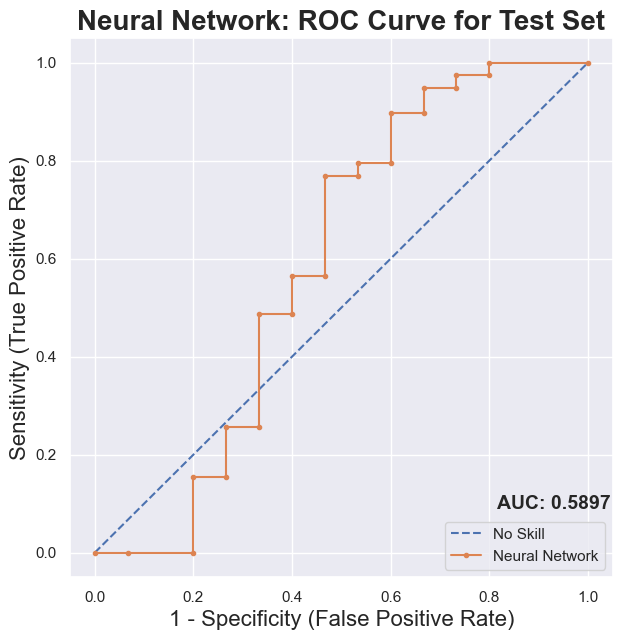

In [240]:
plot_roc_curve('Neural Network')

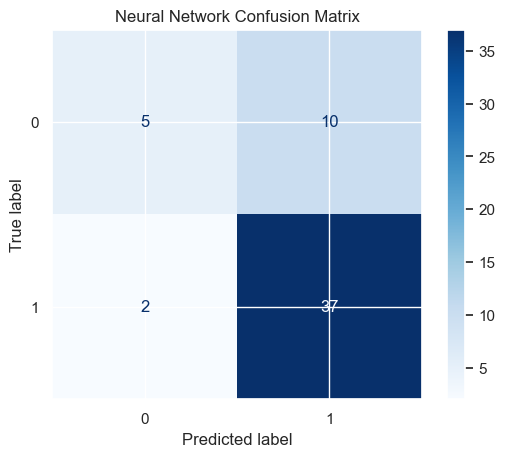

In [241]:
create_confusion_matrix('Neural Network', nn_model, X_test, y_test)